<a href="https://colab.research.google.com/github/Sejmou/ml-ex3/blob/master/notebooks/Data-Exploration_GTSRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition

We will use the [German Traffic Sign Recognition Benchmark (GTSRB) dataset](https://benchmark.ini.rub.de/gtsrb_dataset.html).

This notebook was adapted from [this](https://www.kaggle.com/shivank856/gtsrb-cnn-98-test-accuracy) Kaggle Notebook and the data loading [example code](http://benchmark.ini.rub.de/Dataset/GTSRB_Python_code.zip) on the dataset website.

## Importing Required Libraries

In [1]:
from io import BytesIO
from zipfile import ZipFile
import requests
import csv
import math

import os
import shutil
from collections import defaultdict
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import tensorflow as tf
from tensorflow import keras
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.random.seed(42)

# import our own helper scripts from helper_scripts module in our GitHub repo
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # we have to clone our GitHub repo to fetch the helper scripts and add folder of clone repo to path before they can be imported
  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}')
    print('appended helper_scripts module to sys.path')

from helper_scripts.data_exploration import show_img

Notebook running on Google Colab
Installing GitPython using pip
cloning our git repo to get helper scripts
cloned successfully
appending helper_scripts module to sys.path


## Download data

In [ ]:
# remove unnecessary sample_data folder (present if running on Colab)
shutil.rmtree('./sample_data/', ignore_errors=True)# will fail if folder not present -> ignore error

In [ ]:
train_link = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip'
test_imgs_link = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip'
test_labels_link = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip'

# pre-computed Histogram of Gradients (HoG) features - might be useful for more traditional approaches image recognition
train_hog_link = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_HOG.zip'
test_hog_link = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_HOG.zip'

In [ ]:
def download_and_extract_zip(url):
  zip_bytes = requests.get(url).content
  z = ZipFile(BytesIO(zip_bytes))
  z.extractall(".")

In [ ]:
download_and_extract_zip(train_link)
download_and_extract_zip(test_labels_link)
download_and_extract_zip(test_imgs_link)

## Check downloaded data

In [ ]:
!ls

In [ ]:
def list_files(startpath):# adapted from https://stackoverflow.com/a/9728478/13727176
  '''helper function for getting overview of files/folders within given startpath (incl. subfolders and containing files)
  '''

  def get_file_extension_and_name(filename):
    file_and_extension = filename.split(sep='.')
    extension = file_and_extension[-1] if len(file_and_extension) > 1 else '(No extension)'
    return extension, filename

  for root, dirs, files in os.walk(startpath):
    dirs = dirs.sort() 

    files_by_extension = defaultdict(list)
    for ext, filename in [get_file_extension_and_name(f) for f in files]:
      files_by_extension[ext].append(filename)

    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))

    subindent = ' ' * 4 * (level + 1)

    for ext, files in files_by_extension.items():
      filtered_files = files[:5]
      
      for f in filtered_files:
        print('{}{}'.format(subindent, f))
      if len(files) > len(filtered_files):
        remaining_files = len(files) - len(filtered_files)
        more_text = f'... and {remaining_files} other .{ext} files'
        print('{}{}'.format(subindent, more_text))
            
list_files('.')

## Look at Ground Truth files
For example, let's look at the ground truth labels for the test set, `GT-final_test.csv`. The training set images have ground truth label files in their respective directories.

Those Ground Truth files contain metadata that is important especially for associating them with the correct labels.

In [ ]:
test_ground_truth = pd.read_csv('GT-final_test.csv', sep=';')

In [ ]:
test_ground_truth.head()

## Load images into memory

In [ ]:
# this code is adapted from http://benchmark.ini.rub.de/Dataset/GTSRB_Python_code.zip
def read_traffic_signs(rootpath: str, test_label_csv_path=None):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: 
    * path to the traffic sign data, for example './GTSRB/Training'
    * optional path to CSV file for test set Ground Truth labels (if loaded data is test set)

    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels

    if test_label_csv_path: # we should test set: all images in same folder, .csv file with labels at provided path
      with open(test_label_csv_path) as gtFile: # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(f'{rootpath}/{row[0]}')) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label

    else: # training set; all images in one folder, separate .csv file with labels (expected to be in same dir)
      # loop over 42 classes (each in own subdirectory)
      for c in range(0,43):
          prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
          with open(prefix + 'GT-'+ format(c, '05d') + '.csv') as gtFile: # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
                labels.append(row[7]) # the 8th column is the label

    return images, labels

In [ ]:
train_path = './GTSRB/Final_Training/Images'
test_path = './GTSRB/Final_Test/Images'
test_label_csv_path = './GT-final_test.csv'

In [ ]:
train_imgs, train_labels = read_traffic_signs(train_path)
test_imgs, test_labels = read_traffic_signs(test_path, test_label_csv_path)

## Exploring The Dataset

### Identifying The Classes/Categories

How many categories are there?

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

What are the categories? Let's try to find out by plotting one example image from each class:



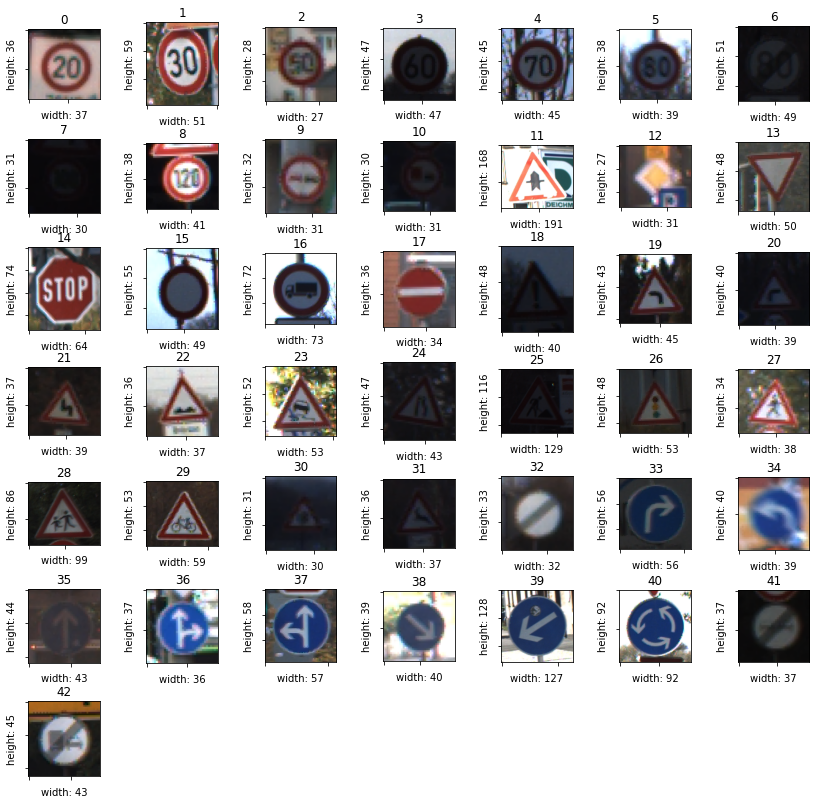

In [ ]:
def get_imgs_per_class_label(imgs, labels):
  '''
  returns a dictionary (key: class label, value: list of images)
  '''
  imgs_by_class = defaultdict(list)
  for i, label in enumerate(labels):
    imgs_by_class[label].append(imgs[i])
  return imgs_by_class

# Visualizing one random image from each class (in the training set)
def plot_random_img_per_class_label(imgs_by_class):
  no_of_labels = len(imgs_by_class.keys())
  # we want to plot one image for each class in a "large enough" quadratic grid
  grid_cols = grid_rows = math.ceil(math.sqrt(no_of_labels)) 

  plt.figure(figsize=(grid_cols * 2, grid_rows * 2))
  plt.subplots_adjust(wspace=0.65, hspace=0.3)
  # iterate over dict containings lists of images  for each class
  for i, (class_label, imgs) in enumerate(imgs_by_class.items()):
    plt.subplot(grid_cols, grid_rows, i + 1)
    
    rand_img = imgs[np.random.choice(len(imgs))]
    plt.imshow(rand_img)

    ax = plt.gca()
    ax.set_title(class_label)

    # we don't need ticks
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel(f'width: {rand_img.shape[1]}')
    ax.set_ylabel(f'height: {rand_img.shape[0]}')

train_imgs_per_class = get_imgs_per_class_label(train_imgs, train_labels)
plot_random_img_per_class_label(train_imgs_per_class)

By looking at an example image for each class in the training set, we now know that the class IDs actually mean:

In [ ]:
# mapping of numeric label to text label
text_labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Let's do a quick sanity-check that the class labels are also correct for the test set.

We can map the numeric test set labels to the text labels using the dictionary we defined above and provide those labels to the plot function to check if everything is indeed correctly mapped:

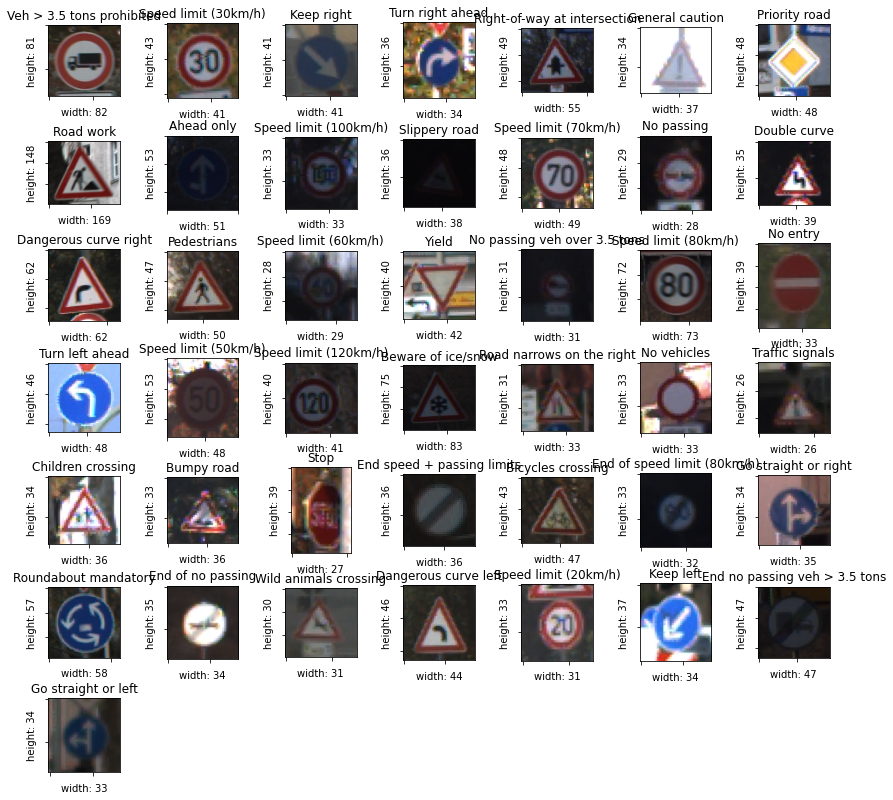

In [ ]:
text_test_labels = [text_labels[int(label)] for label in test_labels]

test_imgs_per_text_label = get_imgs_per_class_label(test_imgs, text_test_labels)

plot_random_img_per_class_label(test_imgs_per_text_label)

Looks good!

### Check Class Distributions for Train and Test Set

In [ ]:
def get_img_class_counts(imgs_per_class_label):
  labels = list(imgs_per_class_label.keys())
  img_counts = [len(imgs_per_class_label[label]) for label in labels]
  label_freqs = pd.DataFrame({'Label': labels, 'Count': img_counts})
  return label_freqs.sort_values('Count')

def plot_img_class_counts(img_class_counts):
  img_class_counts.plot.bar(x='Label', y='Count',
                            figsize=(img_class_counts.shape[0]/2, img_class_counts.shape[0]/6))
  #plt.xticks(class_num, rotation='vertical')

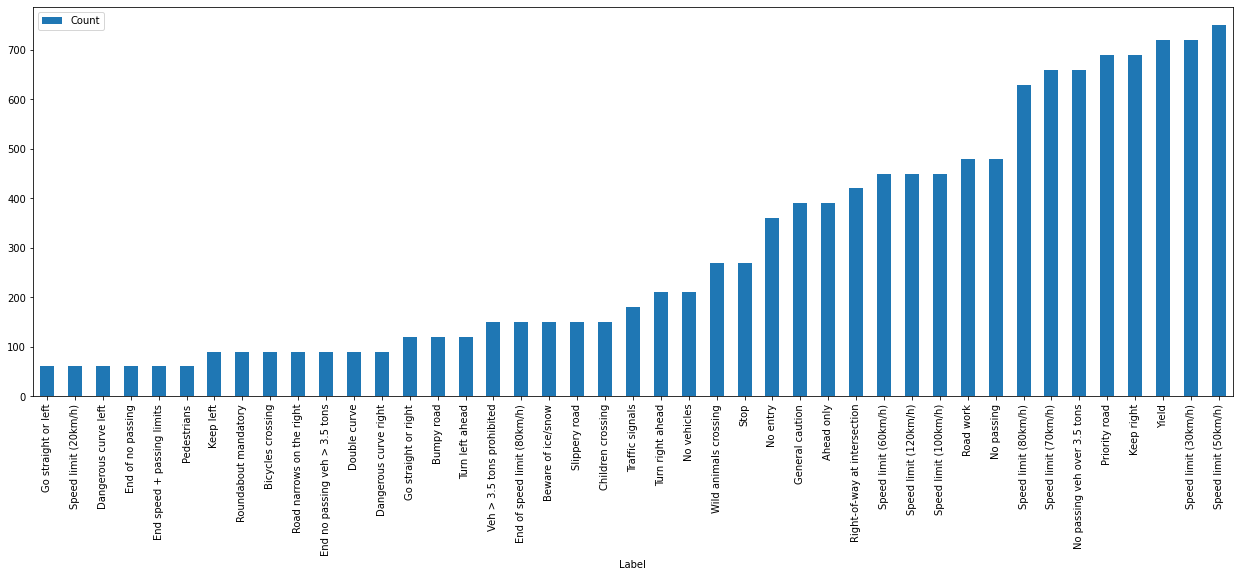

In [ ]:
test_img_class_counts = get_img_class_counts(test_imgs_per_text_label)
plot_img_class_counts(test_img_class_counts)

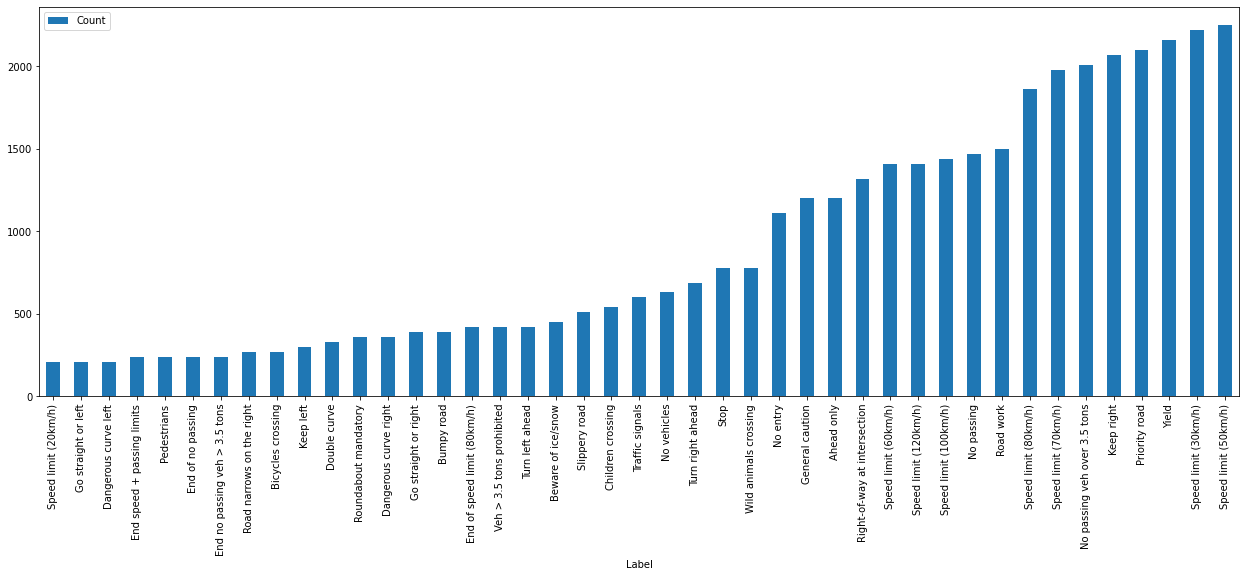

In [ ]:
text_train_labels = [text_labels[int(label)] for label in train_labels]
train_imgs_per_text_label = get_imgs_per_class_label(train_imgs, text_train_labels)
train_img_class_counts = get_img_class_counts(train_imgs_per_text_label)
plot_img_class_counts(train_img_class_counts)


Are the relative class frequencies equally distributed between the training and test splits?

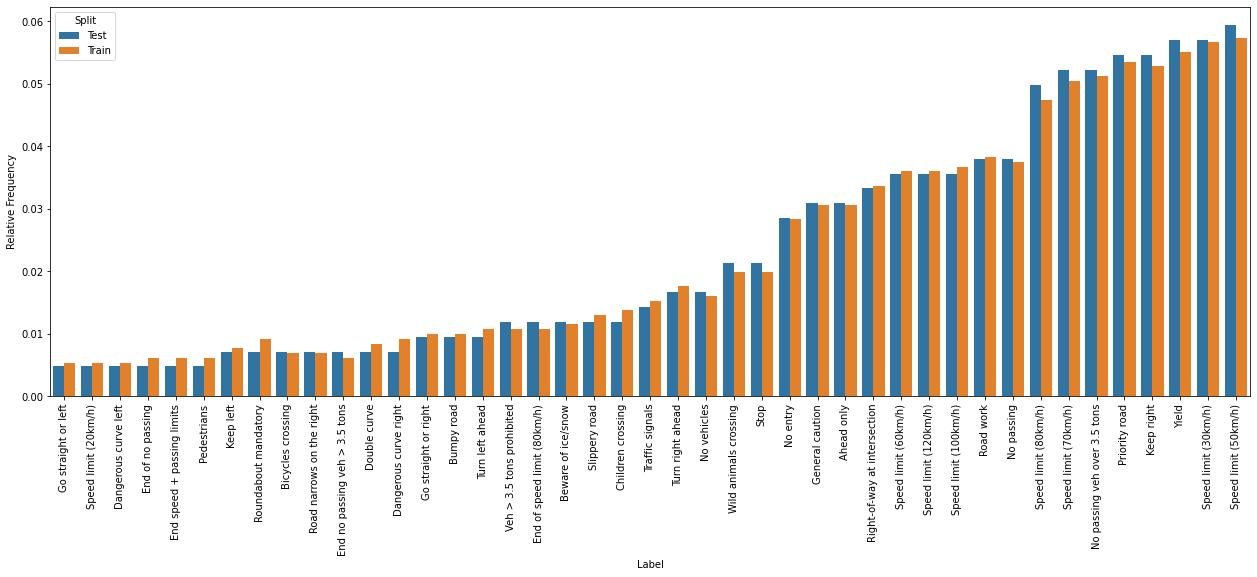

In [ ]:
def get_class_freqs(img_class_counts):
  cpy = img_class_counts.copy()
  cpy.columns = ['Label','Relative Frequency']
  cpy['Relative Frequency'] = cpy['Relative Frequency']/cpy['Relative Frequency'].sum()
  return cpy

train_class_freqs = get_class_freqs(train_img_class_counts)
train_class_freqs['Split'] = 'Train'
test_class_freqs = get_class_freqs(test_img_class_counts)
test_class_freqs['Split'] = 'Test'

dataset_class_freqs = pd.concat([test_class_freqs, train_class_freqs])
plt.figure(figsize=(dataset_class_freqs.shape[0]/4, dataset_class_freqs.shape[0]/12))
plt.xticks(rotation=90)
sns.barplot(x='Label', y='Relative Frequency', hue='Split',
            data=dataset_class_freqs)

Looks good!

## Preparing The Data for Classification

The training data is currently not shuffled, as we loaded it folder by folder (class by class). Furthermore, we already noticed that the image sizes differ (see plots of random images from dataset above).

### Resize images to 32x32 pixels

In [ ]:
type(train_imgs[0])

numpy.ndarray

In [ ]:
train_imgs[0].shape

(30, 29, 3)

To resize "the proper way" (with interpolation), we must use an image processing library. Each image is currently stored in a NumPy `ndarray`. We create an instance of `PIL.Image`, call the `resize()` method on it, and convert it back to a NumPy array.

In [ ]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
COLOR_CHANNELS = 3

def resize_img(img_arr):
  img = Image.fromarray(img_arr, 'RGB')
  resized_img = img.resize((IMG_HEIGHT, IMG_WIDTH))
  return np.array(resized_img)

In [ ]:
demo_img_resized = resize_img(test_imgs[0])
demo_img_resized.shape

(32, 32, 3)

In [ ]:
max([img.max() for img in train_imgs])

255

In [ ]:
min([img.min() for img in train_imgs])

0

The color values of the images range from 0 to 255. We should also normalize them to the [0, 1] range (by dividing by 255)

In [ ]:
def process_imgs(imgs):
  imgs_processed = np.array([resize_img(img) for img in imgs])
  imgs_processed= imgs_processed/255
  return imgs_processed

In [ ]:
train_imgs_processed = process_imgs(train_imgs)
test_imgs_processed = process_imgs(test_imgs)

In [ ]:
train_imgs_processed.shape

(39209, 32, 32, 3)

In [ ]:
test_imgs_processed.shape

(12630, 32, 32, 3)

In [ ]:
count_test = test_imgs_processed.shape[0]
count_train = train_imgs_processed.shape[0]

train_perc = round(count_test/(count_test + count_train), 2)
f'{count_test + count_train} imgs in dataset, train/test ratio is {train_perc}:{1-train_perc}'

'51839 imgs in dataset, train/test ratio is 0.24:0.76'

### Shuffling "Training Data", Splitting Into Training + Validation Data

We need to split the "training data" of the dataset further into training + validation sets. The model will be trained on this (smaller) "true training set" and the validation set will be used to find the optimal parameters. 

We cannot use the test set for both parameter optimization (model fit) and performance evaluation as this would introduce data leakage. If we use the test set both for parameter estimation and testing of the fitted model, the error estimate would be too optimistic - the test data isn't really "unseen".

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_imgs_processed, np.array(train_labels), test_size=0.3, random_state=42, shuffle=True)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


### One-Hot-Encoding of Labels

In [ ]:
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val_ohe = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train_ohe.shape)
print(y_val_ohe.shape)

(27446, 43)
(11763, 43)


## Making the model

In [ ]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train_ohe, batch_size=32), epochs=epochs, validation_data=(X_val, y_val_ohe))

## Evaluating the model

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading Test Data, Predicting, Evaluating Results

In [ ]:
X_test = test_imgs_processed
y_test = np.array(test_labels).astype(int)

y_preds = model.predict(X_test)# matrix; row: observation, col: prob. for class
y_pred = np.argmax(y_preds, axis=1)
print('Test Data accuracy (%): ', accuracy_score(y_test, y_pred)*100)

## Visualizing the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)

In [ ]:
df_cm = pd.DataFrame(cf, index = text_labels,  columns = text_labels)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

## Predictions on Test Data

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = y_pred[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()